# Part 1: Introduction to Reinforcement Learning

Welcome to this comprehensive tutorial on Reinforcement Learning (RL)! In this first notebook, we'll cover the fundamental concepts that distinguish RL from other machine learning paradigms.

## What You'll Learn
- What makes Reinforcement Learning unique
- The reward hypothesis
- Agent-environment interaction
- States and the Markov property
- RL agent components (Policy, Value Function, Model)
- Types of RL agents

Let's begin!

## Setup

First, let's import the necessary libraries and set up our environment.

> **Note:** If you're running this in a fresh environment (like Google Colab or a new virtualenv), uncomment and run the installation cell below first.

In [1]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


---
# 1. What is Reinforcement Learning?

Reinforcement Learning is a type of machine learning where an **agent** learns to make decisions by interacting with an **environment**. Unlike supervised learning (where we have labeled data) or unsupervised learning (where we find patterns in data), RL learns from **trial and error**.

## Key Characteristics of RL

RL has several unique characteristics that distinguish it from other machine learning paradigms:

| Characteristic | Description | FrozenLake Example |
|---------------|-------------|---------------------|
| **No supervisor** | There's no teacher telling the agent what the correct action is. Instead, there's only a reward signal indicating how good or bad an action was. | The agent isn't told "go RIGHT here" or "avoid this path." It only receives +1 for reaching the Goal and 0 otherwise. It must discover the correct path through trial and error. |
| **Delayed feedback** | The reward may come much later after the action was taken. A chess move might only prove good or bad many moves later. | The agent receives reward only at the end of an episode (reaching Goal or falling into a Hole). All intermediate moves on frozen tiles give 0 reward, so the agent doesn't know if early moves were good until much later. |
| **Sequential data** | Data is not i.i.d. (independent and identically distributed). Current observations depend on previous actions. | The state the agent sees depends entirely on its previous actions. Being in state 6 means the agent took a specific sequence of moves from the start. Each observation is a direct consequence of prior decisions. |
| **Actions affect future** | The agent's actions influence the data it will receive in the future. This creates a feedback loop. | Moving DOWN from state 0 leads to states 4 or below, while moving RIGHT leads to states 1 or to the right. The agent's choice determines which parts of the grid it will experience and whether it encounters Holes or the Goal. |

## The Reward Signal

The **reward** $R_t$ is a scalar feedback signal that indicates how well the agent is doing at time step $t$.

The agent's goal is to **maximize the cumulative reward** over time, not just the immediate reward.

$$\text{Goal: Maximize } \sum_{t=0}^{\infty} R_t$$

### The Reward Signal in FrozenLake

In the FrozenLake environment, the reward structure is simple but instructive:

| Event | Reward | Meaning |
|-------|--------|---------|
| Step on Frozen tile (F) | 0 | No immediate feedback - the agent doesn't know if it's on the right path |
| Fall into Hole (H) | 0 | Episode ends with no reward - the agent failed |
| Reach Goal (G) | +1 | Episode ends successfully - this is the only positive signal |

This **sparse reward** structure makes learning challenging:
- The agent receives the same reward (0) for safe moves and falling into holes
- Only reaching the Goal provides a positive signal
- The agent must learn to associate earlier actions with the eventual outcome

### How Can the Agent Maximize Reward in FrozenLake?

Since the only positive reward (+1) comes from reaching the Goal, the agent maximizes cumulative reward by:

1. **Finding paths that lead to the Goal** - The agent must discover which sequences of actions successfully navigate from S to G

2. **Avoiding Holes** - Falling into a Hole ends the episode with 0 total reward, so the agent must learn to steer away from H tiles

3. **Handling the slippery ice** - Since the ice is slippery, the intended action only succeeds 1/3 of the time. The agent must learn policies that are robust to this stochasticity (e.g., staying away from Holes even when "pushed" by the slippery ice)

4. **Reaching the Goal quickly (with discounting)** - When using a discount factor $\gamma < 1$, reaching the Goal sooner yields a higher present value. A reward of +1 received after 5 steps is worth $\gamma^5$, while +1 after 10 steps is worth only $\gamma^{10}$

**In practice**, the agent maximizes reward through trial and error:
- It tries random actions and observes outcomes
- Episodes that reach the Goal (+1) reinforce the actions taken
- Episodes that fall into Holes (0) discourage those action sequences
- Over many episodes, the agent learns which state-action combinations lead to success

### The Reward Hypothesis

> **"All goals can be described as the maximization of expected cumulative reward."**

This is a foundational assumption in RL. While powerful, it's also debated:

**Arguments for:**
- Many complex behaviors can indeed be expressed as reward maximization
- It provides a unified framework for decision-making

**Arguments against:**
- Some goals (curiosity, creativity, ethics) are hard to quantify as a single scalar
- Designing the right reward function (reward shaping) is often very challenging

**FrozenLake perspective:** The goal "navigate to the Goal without falling into Holes" is captured by +1 for reaching G and 0 otherwise. However, this sparse reward makes it hard for the agent to learn - it gets no signal about progress until the very end.

## Sequential Decision Making

The goal of sequential decision making is to select actions that **maximize total future reward**.

Key insight: Actions may have **long-term consequences**, and rewards may be **delayed**. Sometimes it's better to sacrifice immediate reward for greater long-term gain.

### Examples:

1. **Financial investment**: You invest money today (losing immediate spending power) for returns months or years later.

2. **Helicopter refueling**: Refueling now (taking time away from the mission) prevents crashes hours later.

3. **Chess**: Sacrificing a piece now might lead to checkmate many moves later.

4. **Education**: Studying hard now (foregoing leisure) leads to better career opportunities later.

### Sequential Decision Making in FrozenLake

FrozenLake is a perfect example of sequential decision making. Let's break down why:

#### Why is it Sequential?

Each decision depends on where you are, and where you are depends on all previous decisions:

```
Step 1: At S (state 0) → Choose DOWN → Move to state 4
Step 2: At state 4 → Choose DOWN → Move to state 8
Step 3: At state 8 → Choose RIGHT → Move to state 9
...and so on until reaching G or falling into H
```

The agent cannot jump directly to the Goal - it must navigate through a **sequence of states**, and each action opens or closes future possibilities.

#### How Does This Affect Decisions?

Consider the agent at **state 6** (middle-left area of the grid):

| Option | Immediate Effect | Long-term Consequence |
|--------|------------------|----------------------|
| Go RIGHT | Move toward center | Gets closer to Goal, but also closer to Hole at state 7 |
| Go DOWN | Move toward bottom | Safer path, but longer route to Goal |
| Go LEFT | Move toward edge | Moves away from Goal, wastes steps |
| Go UP | Move toward top | Risk of Hole at state 5 |

The "best" action isn't obvious from immediate rewards (all give 0) - it depends on what happens **many steps later**.

#### Trade-offs and Sacrifices in FrozenLake

Unlike chess where you might sacrifice a piece, in FrozenLake the "sacrifices" are more subtle:

| Sacrifice | Short-term Cost | Long-term Benefit |
|-----------|-----------------|-------------------|
| **Taking a longer path** | More steps, lower discounted reward | Avoids Holes, higher probability of reaching Goal |
| **Moving away from Goal temporarily** | Increases distance to reward | May avoid a dangerous Hole in the direct path |
| **Staying near edges** | Limits movement options | Reduces risk of slipping into Holes |

#### A Concrete Example: The Greedy Trap

```
Grid layout (4x4):
S  F  F  F      States: 0  1  2  3
F  H  F  H              4  5  6  7
F  F  F  H              8  9  10 11
H  F  F  G              12 13 14 15
```

**Greedy approach** (always move toward Goal):
- From state 0: Go RIGHT and DOWN as directly as possible toward state 15
- Problem: This path goes through states 5, 7, or 11 - all Holes!

**Sequential thinking approach**:
- From state 0: Go DOWN first (states 0→4→8), then navigate around Holes
- The path S→4→8→9→10→14→15 avoids all Holes
- Even though going DOWN initially moves "sideways" relative to the Goal, it's the winning strategy

#### The Key Insight

In FrozenLake, the agent must learn that:
- **Immediate progress toward the Goal can be fatal** (Holes block direct paths)
- **Seemingly suboptimal moves may be necessary** (going around Holes)
- **The slippery ice adds uncertainty** - even "safe" moves might slip into danger
- **Every decision shapes future options** - one wrong move can make the Goal unreachable

This is the essence of sequential decision making: **optimize for the cumulative outcome, not each individual step**.

---
# 2. The Agent-Environment Interface

In RL, we have two main entities:

1. **Agent**: The learner and decision maker
2. **Environment**: Everything outside the agent that it interacts with

## The Interaction Loop

At each time step $t$:

**Agent:**
- Receives observation $O_t$
- Receives reward $R_t$
- Executes action $A_t$

**Environment:**
- Receives action $A_t$
- Emits observation $O_{t+1}$
- Emits reward $R_{t+1}$

```
    ┌────────────────────────────────────────┐
    │                                        │
    │    ┌───────┐         ┌─────────────┐   │
    │    │       │  Action │             │   │
    │    │ Agent │────────►│ Environment │   │
    │    │       │         │             │   │
    │    └───────┘◄────────└─────────────┘   │
    │        ▲    Observation, Reward        │
    │        │                               │
    └────────┼───────────────────────────────┘
             │
         Time step t
```

## The History

The **history** $H_t$ is the sequence of all observations, actions, and rewards up to time $t$:

$$H_t = O_1, R_1, A_1, O_2, R_2, A_2, \ldots, A_{t-1}, O_t, R_t$$

This is everything that has happened. The next action (by the agent) and the next observation/reward (by the environment) depend on this history.

## Let's See This in Action: FrozenLake Environment

We'll use the **FrozenLake** environment from Gymnasium. This is a simple grid world where:

- **S** (Start): Starting position
- **F** (Frozen): Safe frozen surface (you can walk on it)
- **H** (Hole): Hole in the ice (falling in ends the episode with 0 reward)
- **G** (Goal): The goal (reaching it gives reward of 1)

The agent can take 4 actions:
- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

**Note**: The ice is slippery! The agent might not always move in the intended direction.

In [3]:
# Create the FrozenLake environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)

# Reset the environment to get the initial observation
observation, info = env.reset(seed=42)

print("FrozenLake Environment")
print("=" * 40)
print(f"\nState space: {env.observation_space}")
print(f"Number of states: {env.observation_space.n}")
print(f"\nAction space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")
print(f"\nInitial observation (state): {observation}")

FrozenLake Environment

State space: Discrete(16)
Number of states: 16

Action space: Discrete(4)
Number of actions: 4

Initial observation (state): 0


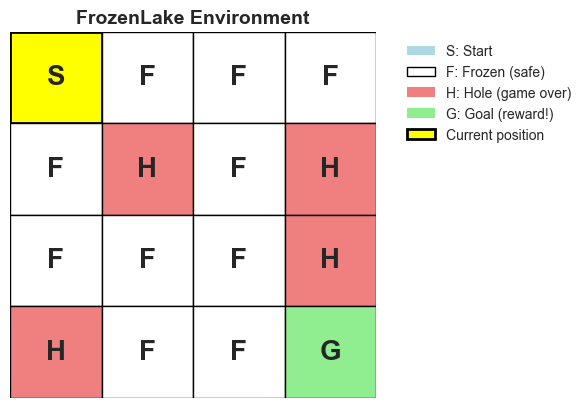

In [4]:
# Helper function to visualize the FrozenLake grid
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    # Get the map
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Color mapping
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    # Draw the grid
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            
            # Highlight current state
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            
            # Add text
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    return fig, ax

# Visualize the environment
visualize_frozenlake(env, current_state=observation)
plt.show()

## The Agent-Environment Interaction in Code

Let's see how the agent interacts with the environment step by step.

> **Note on Episode Endings:** In Gymnasium, an episode can end in two ways:
> - **Terminated**: The agent reached a terminal state (Goal or Hole). The task is "naturally" over.
> - **Truncated**: The episode was cut short by a time limit (e.g., taking too many steps without reaching the goal). This prevents the agent from wandering forever.
>
> The old Gym API used a single `done` flag, but the new Gymnasium API separates these cases because they have different implications for learning (truncated episodes might still have future value, while terminated episodes don't).

In [5]:
# Reset the environment
observation, info = env.reset(seed=42)

print("Step-by-Step Agent-Environment Interaction")
print("=" * 50)
print(f"\nInitial state: {observation}")

# Action names for better readability
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}

# Helper function to compute expected next state (for slip detection)
def get_expected_state(state, action, nrow=4, ncol=4):
    """Calculate where the agent would go if no slip occurred."""
    row, col = state // ncol, state % ncol
    if action == 0:  # LEFT
        col = max(col - 1, 0)
    elif action == 1:  # DOWN
        row = min(row + 1, nrow - 1)
    elif action == 2:  # RIGHT
        col = min(col + 1, ncol - 1)
    elif action == 3:  # UP
        row = max(row - 1, 0)
    return row * ncol + col

# Let's take a few actions and observe the interaction
history = [(observation, None, None)]  # (state, action, reward)

for step in range(5):
    # Agent chooses a random action
    action = env.action_space.sample()
    
    # Environment responds with new observation, reward, and other info
    new_observation, reward, terminated, truncated, info = env.step(action)
    
    history.append((new_observation, action, reward))
    
    # Check if the agent slipped
    expected_state = get_expected_state(observation, action)
    slipped = (new_observation != expected_state)
    slip_msg = " (Slipped!)" if slipped else ""
    
    print(f"\n--- Step {step + 1} ---")
    print(f"  State: {observation}")
    print(f"  Action taken: {action} ({action_names[action]})")
    print(f"  Expected state: {expected_state}")
    print(f"  New state: {new_observation}{slip_msg}")
    print(f"  Reward received: {reward}")
    print(f"  Episode over: {terminated or truncated}")
    
    observation = new_observation
    
    if terminated or truncated:
        print("\n*** Episode ended! ***")
        break

env.close()

Step-by-Step Agent-Environment Interaction

Initial state: 0

--- Step 1 ---
  State: 0
  Action taken: 0 (LEFT)
  Expected state: 0
  New state: 0
  Reward received: 0
  Episode over: False

--- Step 2 ---
  State: 0
  Action taken: 1 (DOWN)
  Expected state: 4
  New state: 1 (Slipped!)
  Reward received: 0
  Episode over: False

--- Step 3 ---
  State: 1
  Action taken: 1 (DOWN)
  Expected state: 5
  New state: 2 (Slipped!)
  Reward received: 0
  Episode over: False

--- Step 4 ---
  State: 2
  Action taken: 1 (DOWN)
  Expected state: 6
  New state: 1 (Slipped!)
  Reward received: 0
  Episode over: False

--- Step 5 ---
  State: 1
  Action taken: 0 (LEFT)
  Expected state: 0
  New state: 5 (Slipped!)
  Reward received: 0
  Episode over: True

*** Episode ended! ***


In [6]:
# Visualize the history
print("\nHistory of the episode:")
print("H_t = ", end="")
for i, (state, action, reward) in enumerate(history):
    if action is None:
        print(f"S{state}", end="")
    else:
        print(f" → A{action}({action_names[action]}) → R{reward}, S{state}", end="")
print()


History of the episode:
H_t = S0 → A0(LEFT) → R0, S0 → A1(DOWN) → R0, S1 → A1(DOWN) → R0, S2 → A1(DOWN) → R0, S1 → A0(LEFT) → R0, S5


---
# 3. State and the Markov Property

## What is State?

The **state** is the information used to determine what happens next. Formally, the state is a function of the history:

$$S_t = f(H_t)$$

The state is a **summary** of the history that captures all relevant information.

## Types of State

### 1. Environment State ($S_t^e$)
- The environment's **internal representation**
- Used by the environment to generate the next observation and reward
- Usually **not visible** to the agent
- May contain irrelevant information

### 2. Agent State ($S_t^a$)
- The agent's **internal representation**
- Used by the agent to select the next action
- Can be any function of the history: $S_t^a = f(H_t)$
- This is what RL algorithms use

## The Markov Property

A state $S_t$ is **Markov** if and only if:

$$P[S_{t+1} | S_t] = P[S_{t+1} | S_1, S_2, \ldots, S_t]$$

In plain English: **"The future is independent of the past, given the present."**

If a state is Markov:
- The state captures all relevant information from the history
- Once we know the current state, the history can be thrown away
- The state is a **sufficient statistic** of the future

### Examples:

**Markov:** In chess, the current board position is Markov. It doesn't matter how we got there - only the current position matters for determining the best move.

**Not Markov:** In poker with hidden cards, just knowing the visible cards isn't Markov - the history of betting might give information about hidden cards.

### Why is FrozenLake Markov?

FrozenLake is a perfect example of a Markov environment. Here's why:

#### The State Contains All Relevant Information

In FrozenLake, the state is simply the agent's position (0-15). This single number tells us everything we need to know:

| What We Know from State | Why It's Sufficient |
|------------------------|---------------------|
| Current position on grid | Determines available actions and their outcomes |
| Distance to Goal | Implicit in position (state 15 is Goal) |
| Nearby Holes | Grid layout is fixed, so position reveals dangers |
| Possible next states | Transition probabilities depend only on current position |

#### The History Doesn't Matter

Consider two different histories that both end in **state 10**:

```
History A: 0 → 4 → 8 → 9 → 10  (came from the left)
History B: 0 → 1 → 2 → 6 → 10  (came from above)
```

**Key insight:** Once the agent is in state 10, the future is identical regardless of how it got there:
- Same actions available (LEFT, DOWN, RIGHT, UP)
- Same transition probabilities (1/3 chance each direction due to slippery ice)
- Same possible next states (6, 9, 11, 14)
- Same reward structure (0 for moves, +1 only at Goal)

The path taken to reach state 10 provides **zero additional information** about what will happen next.

#### Concrete Example: State 9

Suppose the agent is in state 9. The Markov property says:

$$P[S_{t+1} = 10 | S_t = 9, \text{action=RIGHT}] = P[S_{t+1} = 10 | S_0, S_1, \ldots, S_t = 9, \text{action=RIGHT}]$$

No matter what crazy path the agent took to reach state 9:
- Direct path: 0→4→8→9
- Wandering path: 0→1→0→4→5→4→8→9
- Any other path...

The probability of moving to state 10 when taking action RIGHT is always **1/3** (due to slippery ice). The past is irrelevant.

#### Why This Matters

Because FrozenLake is Markov:
1. **Simple state representation** - We only need to track current position, not the entire history
2. **Efficient learning** - The agent can learn values for 16 states instead of infinitely many histories
3. **Optimal policies exist** - We can find a policy that maps states to actions without considering history
4. **Dynamic programming works** - Bellman equations (covered later) rely on the Markov property

#### What Would Make FrozenLake Non-Markov?

If we modified the environment, it could lose the Markov property:

| Modification | Why It Breaks Markov |
|-------------|---------------------|
| Ice weakens with each step on it | Need to track how many times each tile was visited |
| Agent has limited energy based on distance traveled | Need to track total steps taken |
| Holes appear/disappear based on previous actions | Need to remember which actions were taken |
| Wind direction changes based on recent movements | Need to track recent action sequence |

In these cases, the current position alone wouldn't be enough - we'd need additional state information or the full history.

## Fully Observable vs Partially Observable

### Fully Observable Environment (MDP)

When the agent **directly observes** the environment state:

$$O_t = S_t^a = S_t^e$$

- Agent state = Environment state = Information state
- This is called a **Markov Decision Process (MDP)**
- Example: FrozenLake - the agent knows exactly which cell it's in

### Partially Observable Environment (POMDP)

When the agent only **indirectly observes** the environment:

$$O_t \neq S_t^e$$

- Agent state ≠ Environment state
- This is called a **Partially Observable MDP (POMDP)**
- Examples:
  - A robot with a camera doesn't know its exact position
  - A trading agent only sees current prices, not market sentiment
  - A poker player only sees public cards

In POMDPs, the agent must build its own state representation, such as:
- Complete history: $S_t^a = H_t$
- Beliefs (probability distribution over possible states)
- Recurrent neural network: $S_t^a = \sigma(S_{t-1}^a W_s + O_t W_o)$

FrozenLake as a Fully Observable MDP

The observation IS the state: 0
State type: int
Total number of states: 16

In FrozenLake:
- The agent knows exactly which cell it's in
- State = row * 4 + column (for 4x4 grid)
- Current state 0 means row 0, column 0


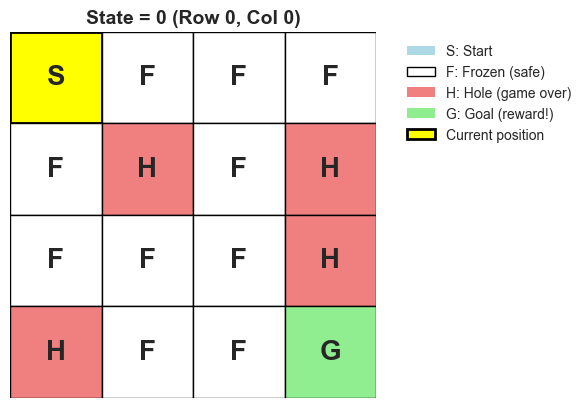

In [7]:
# Demonstrate FrozenLake as a Fully Observable MDP
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
observation, info = env.reset(seed=42)

print("FrozenLake as a Fully Observable MDP")
print("=" * 50)
print(f"\nThe observation IS the state: {observation}")
print(f"State type: {type(observation).__name__}")
print(f"Total number of states: {env.observation_space.n}")
print("\nIn FrozenLake:")
print("- The agent knows exactly which cell it's in")
print("- State = row * 4 + column (for 4x4 grid)")
print(f"- Current state {observation} means row {observation // 4}, column {observation % 4}")

# Visualize
visualize_frozenlake(env, current_state=observation, title=f"State = {observation} (Row {observation // 4}, Col {observation % 4})")
plt.show()

env.close()

---
# 4. Components of an RL Agent

An RL agent may include one or more of these components:

1. **Policy** - How the agent behaves
2. **Value Function** - How good states/actions are
3. **Model** - Agent's representation of the environment

## 4.1 Policy ($\pi$)

The **policy** is the agent's behavior function - it maps states to actions.

### Deterministic Policy

$$a = \pi(s)$$

For a given state, always returns the same action.

### Stochastic Policy

$$\pi(a|s) = P[A_t = a | S_t = s]$$

For a given state, returns a probability distribution over actions.

In [8]:
# Example: Deterministic Policy
def deterministic_policy(state):
    """A simple deterministic policy: always go RIGHT (action 2)."""
    return 2  # Always RIGHT

# Example: Another Deterministic Policy
def go_down_policy(state):
    """A simple deterministic policy: always go DOWN (action 1)."""
    return 1  # Always DOWN

print("Deterministic Policy Examples")
print("=" * 40)
for state in range(4):
    print(f"State {state}: deterministic_policy returns action {deterministic_policy(state)} (RIGHT)")
    print(f"State {state}: go_down_policy returns action {go_down_policy(state)} (DOWN)")
    print()

Deterministic Policy Examples
State 0: deterministic_policy returns action 2 (RIGHT)
State 0: go_down_policy returns action 1 (DOWN)

State 1: deterministic_policy returns action 2 (RIGHT)
State 1: go_down_policy returns action 1 (DOWN)

State 2: deterministic_policy returns action 2 (RIGHT)
State 2: go_down_policy returns action 1 (DOWN)

State 3: deterministic_policy returns action 2 (RIGHT)
State 3: go_down_policy returns action 1 (DOWN)



In [9]:
# Example: Stochastic Policy
def uniform_random_policy(state, n_actions=4):
    """Uniform random policy: equal probability for all actions."""
    return np.ones(n_actions) / n_actions

def biased_policy(state, n_actions=4):
    """A biased policy: prefers going DOWN and RIGHT."""
    # [LEFT, DOWN, RIGHT, UP]
    return np.array([0.1, 0.4, 0.4, 0.1])

print("Stochastic Policy Examples")
print("=" * 40)
print("\nUniform Random Policy (same for all states):")
probs = uniform_random_policy(0)
action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
for action, prob in enumerate(probs):
    print(f"  P(A={action}|S=0) = {prob:.2f} ({action_names[action]})")

print("\nBiased Policy (prefers DOWN and RIGHT):")
probs = biased_policy(0)
for action, prob in enumerate(probs):
    print(f"  P(A={action}|S=0) = {prob:.2f} ({action_names[action]})")

Stochastic Policy Examples

Uniform Random Policy (same for all states):
  P(A=0|S=0) = 0.25 (LEFT)
  P(A=1|S=0) = 0.25 (DOWN)
  P(A=2|S=0) = 0.25 (RIGHT)
  P(A=3|S=0) = 0.25 (UP)

Biased Policy (prefers DOWN and RIGHT):
  P(A=0|S=0) = 0.10 (LEFT)
  P(A=1|S=0) = 0.40 (DOWN)
  P(A=2|S=0) = 0.40 (RIGHT)
  P(A=3|S=0) = 0.10 (UP)


Sampling Actions from Policies


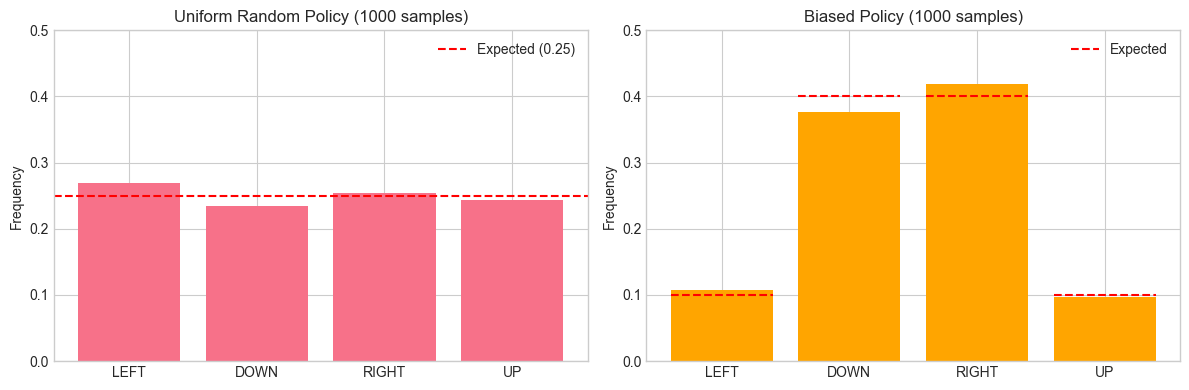

In [10]:
# Sample from a stochastic policy
def sample_action(policy_probs):
    """Sample an action according to the policy probabilities."""
    return np.random.choice(len(policy_probs), p=policy_probs)

# Demonstrate sampling from policies
print("Sampling Actions from Policies")
print("=" * 40)

n_samples = 1000

# Sample from uniform random policy
uniform_samples = [sample_action(uniform_random_policy(0)) for _ in range(n_samples)]
uniform_counts = np.bincount(uniform_samples, minlength=4)

# Sample from biased policy
biased_samples = [sample_action(biased_policy(0)) for _ in range(n_samples)]
biased_counts = np.bincount(biased_samples, minlength=4)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(action_names, uniform_counts / n_samples)
axes[0].set_title(f'Uniform Random Policy ({n_samples} samples)')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim(0, 0.5)
axes[0].axhline(y=0.25, color='r', linestyle='--', label='Expected (0.25)')
axes[0].legend()

axes[1].bar(action_names, biased_counts / n_samples, color='orange')
axes[1].set_title(f'Biased Policy ({n_samples} samples)')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(0, 0.5)
# Add expected lines
expected = [0.1, 0.4, 0.4, 0.1]
for i, exp in enumerate(expected):
    axes[1].plot([i-0.4, i+0.4], [exp, exp], 'r--')
axes[1].plot([], [], 'r--', label='Expected')  # For legend
axes[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Run episodes with different policies and compare results
def run_episode(env, policy_fn, max_steps=100):
    """Run a single episode with the given policy."""
    observation, info = env.reset()
    total_reward = 0
    steps = 0
    
    for _ in range(max_steps):
        # Get action from policy
        policy_output = policy_fn(observation)
        
        # If policy returns probabilities, sample; otherwise use directly
        if isinstance(policy_output, np.ndarray):
            action = sample_action(policy_output)
        else:
            action = policy_output
        
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        
        if terminated or truncated:
            break
    
    return total_reward, steps

# Compare policies over multiple episodes
env = gym.make("FrozenLake-v1", is_slippery=True)
n_episodes = 1000

policies = {
    'Uniform Random': uniform_random_policy,
    'Biased (DOWN/RIGHT)': biased_policy,
    'Always RIGHT': lambda s: 2,
    'Always DOWN': lambda s: 1
}

results = {}
for name, policy in policies.items():
    rewards = []
    for _ in range(n_episodes):
        reward, _ = run_episode(env, policy)
        rewards.append(reward)
    results[name] = rewards
    print(f"{name}: Success rate = {np.mean(rewards)*100:.1f}%")

env.close()

Uniform Random: Success rate = 1.8%
Biased (DOWN/RIGHT): Success rate = 2.5%
Always RIGHT: Success rate = 3.5%
Always DOWN: Success rate = 3.5%


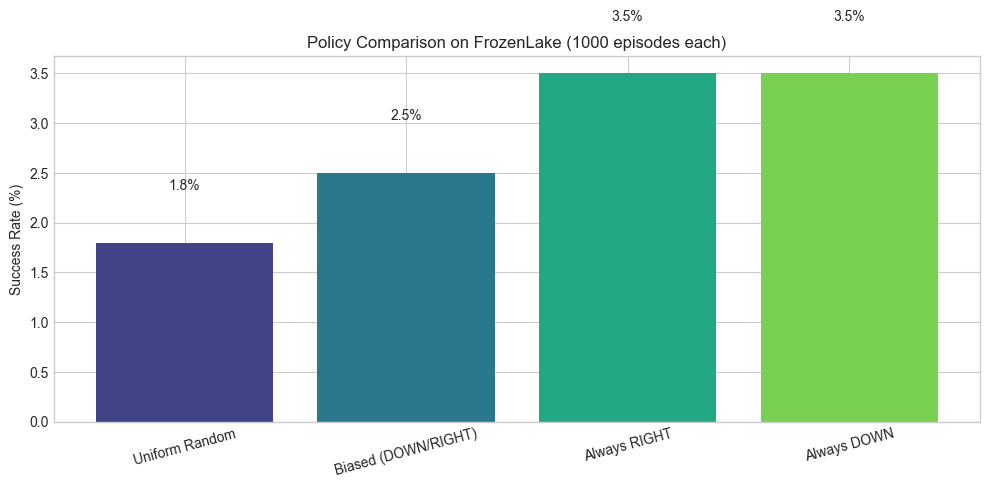

In [12]:
# Visualize policy comparison
fig, ax = plt.subplots(figsize=(10, 5))

success_rates = [np.mean(results[name]) * 100 for name in policies.keys()]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(policies)))

bars = ax.bar(policies.keys(), success_rates, color=colors)
ax.set_ylabel('Success Rate (%)')
ax.set_title(f'Policy Comparison on FrozenLake ({n_episodes} episodes each)')

# Add value labels on bars
for bar, rate in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Understanding the Results: How Can "Always DOWN" Reach the Goal?

Looking at the results above, you might wonder: if the "Always DOWN" policy only chooses to go down, how can it ever reach the Goal at state 15 (bottom-right corner)? The agent starts at state 0 (top-left) and the Goal is diagonally across!

The answer lies in the **slippery ice**. When the agent chooses an action, it only moves in that direction **1/3 of the time**. The other 2/3 of the time, it slips perpendicular to the intended direction:

| Intended Action | Actual Movement Probabilities |
|----------------|------------------------------|
| DOWN | 1/3 DOWN, 1/3 LEFT, 1/3 RIGHT |
| RIGHT | 1/3 RIGHT, 1/3 UP, 1/3 DOWN |
| UP | 1/3 UP, 1/3 LEFT, 1/3 RIGHT |
| LEFT | 1/3 LEFT, 1/3 UP, 1/3 DOWN |

#### Why "Always DOWN" Achieves ~4% Success

Even though the policy only chooses DOWN, the slippery ice causes unintended movements:

```
Intended: DOWN     Actual possibilities:
    ↓                  ← ↓ →
                      (1/3 each)
```

**A typical failed episode:**
```
State 0:  Choose DOWN → Slip RIGHT → State 1
State 1:  Choose DOWN → Actually go DOWN → State 5 (HOLE!) ❌
```

**A successful (lucky!) episode:**
```
State 0:  Choose DOWN → Actually go DOWN → State 4
State 4:  Choose DOWN → Actually go DOWN → State 8
State 8:  Choose DOWN → Slip RIGHT → State 9
State 9:  Choose DOWN → Slip RIGHT → State 10
State 10: Choose DOWN → Actually go DOWN → State 14
State 14: Choose DOWN → Slip RIGHT → State 15 (GOAL!) ✓
```

The ~4% success rate emerges from:
1. **Random slips toward the Goal** - The agent "accidentally" moves right due to slipping
2. **Avoiding Holes by chance** - Sometimes the random movements happen to miss the Holes
3. **Many attempts** - Over 1000 episodes, some get lucky enough to reach the Goal

#### The Paradox: Deterministic Policy, Random Outcomes

This illustrates an important RL concept: **even a deterministic policy produces different outcomes in a stochastic environment**.

- The policy is deterministic: always outputs "DOWN"
- But the outcomes are random: the agent ends up in different states each episode
- Success depends on the random transitions, not the policy's "skill"

A **good** policy would account for this stochasticity. For example, if you're near a Hole on your left, you might choose to go RIGHT so that even if you slip LEFT or DOWN, you're less likely to fall in. This is why learning optimal policies in stochastic environments is challenging and interesting!

### Your Turn: Create a "Safe" Policy

Now it's your turn to experiment! Try writing a deterministic policy that attempts to avoid holes by being more strategic about its movements.

**Exercise:** Create a `safe_policy(state)` function that:
1. For states in the top row (0, 1, 2, 3): always go DOWN to avoid slipping into holes to the right
2. For states in the left column (0, 4, 8): always go DOWN to stay in the "safe corridor"
3. For other states: go RIGHT to move toward the goal

Run the simulation with your policy and compare its success rate to the policies above. Does it work better than random? Why or why not?

**Hint:** Even a "smart" policy struggles because of the slippery ice - but can you beat 4.5%?

In [13]:
# YOUR TURN: Implement a "safe" policy
# Uncomment and complete the function below, then run the cell to test it!

# def safe_policy(state):
#     """
#     A policy that tries to avoid holes by navigating strategically.
#     
#     Grid layout (4x4):
#     S  F  F  F      States: 0  1  2  3
#     F  H  F  H              4  5  6  7
#     F  F  F  H              8  9  10 11
#     H  F  F  G              12 13 14 15
#     
#     Actions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP
#     """
#     # Top row (states 0, 1, 2, 3) - go DOWN
#     if state in [0, 1, 2, 3]:
#         return 1  # DOWN
#     
#     # Left column (states 4, 8) - go DOWN  
#     elif state in [4, 8]:
#         return 1  # DOWN
#     
#     # TODO: Add your logic for other states
#     # Hint: Think about how to navigate from the bottom-left toward the goal
#     else:
#         return 2  # RIGHT (default)

# # Test your policy
# env = gym.make("FrozenLake-v1", is_slippery=True)
# n_episodes = 1000
# rewards = []
# for _ in range(n_episodes):
#     reward, _ = run_episode(env, safe_policy)
#     rewards.append(reward)
# print(f"Your Safe Policy: Success rate = {np.mean(rewards)*100:.1f}%")
# env.close()

## 4.2 Value Function

The **value function** tells us how good a state (or state-action pair) is.

$$V^\pi(s) = E_\pi[G_t | S_t = s] = E_\pi[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots | S_t = s]$$

Where:
- $G_t$ is the **return** (total discounted future reward)
- $\gamma$ (gamma) is the **discount factor** $\in [0, 1]$

The value function predicts the expected future reward from a state, following policy $\pi$.

### The Discount Factor $\gamma$

The discount factor determines how much we value future rewards:

- $\gamma = 0$: Only care about immediate reward ("myopic")
- $\gamma = 1$: All future rewards equally important ("far-sighted")
- $\gamma \approx 0.9-0.99$: Common in practice

A reward $R$ received $k$ steps in the future is worth $\gamma^k R$ today.

In [14]:
# Visualize the effect of different discount factors
def compute_return(rewards, gamma):
    """Compute the discounted return from a sequence of rewards."""
    G = 0
    for t, r in enumerate(rewards):
        G += (gamma ** t) * r
    return G

# Example: Rewards over 10 steps, with a big reward at the end
rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]  # Reward of 10 at step 9
gammas = [0.0, 0.5, 0.9, 0.99, 1.0]

print("Effect of Discount Factor on Return")
print("=" * 50)
print(f"\nRewards: {rewards}")
print(f"(Big reward of 10 at the end, after 9 steps of 0)\n")

for gamma in gammas:
    G = compute_return(rewards, gamma)
    print(f"γ = {gamma:.2f}: Return G = {G:.4f}")
    if gamma > 0 and gamma < 1:
        print(f"         (10 × {gamma}^9 = 10 × {gamma**9:.6f} = {G:.4f})")

Effect of Discount Factor on Return

Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]
(Big reward of 10 at the end, after 9 steps of 0)

γ = 0.00: Return G = 0.0000
γ = 0.50: Return G = 0.0195
         (10 × 0.5^9 = 10 × 0.001953 = 0.0195)
γ = 0.90: Return G = 3.8742
         (10 × 0.9^9 = 10 × 0.387420 = 3.8742)
γ = 0.99: Return G = 9.1352
         (10 × 0.99^9 = 10 × 0.913517 = 9.1352)
γ = 1.00: Return G = 10.0000


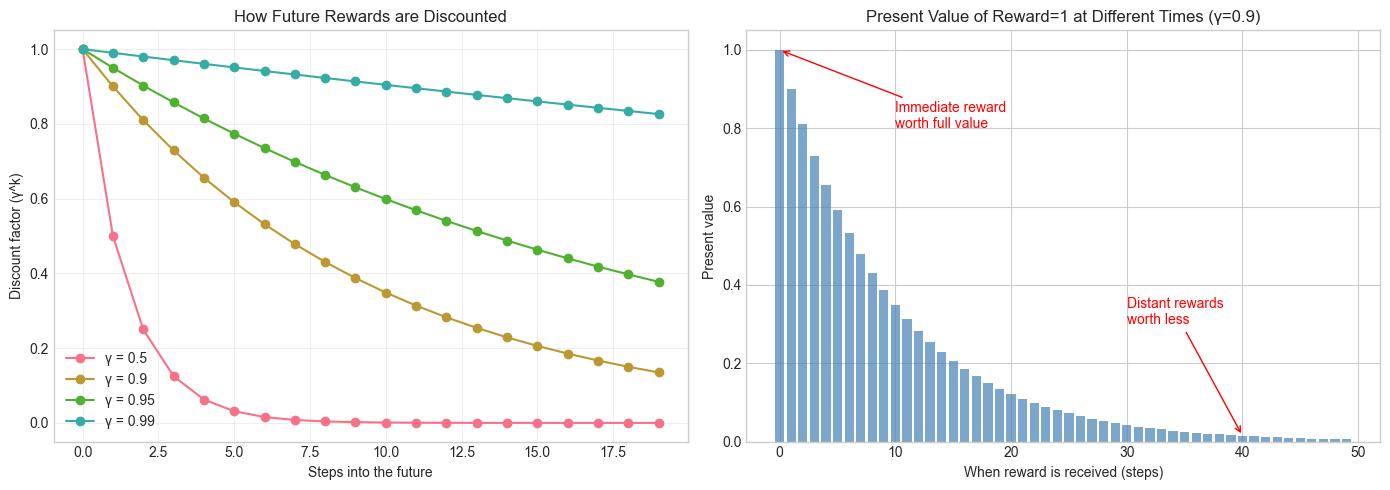

In [15]:
# Visualize discount factor effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: How future rewards are discounted
steps = np.arange(0, 20)
gammas = [0.5, 0.9, 0.95, 0.99]

for gamma in gammas:
    discount_values = gamma ** steps
    axes[0].plot(steps, discount_values, 'o-', label=f'γ = {gamma}')

axes[0].set_xlabel('Steps into the future')
axes[0].set_ylabel('Discount factor (γ^k)')
axes[0].set_title('How Future Rewards are Discounted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Present value of a reward of 1 at different future times
gamma = 0.9
future_times = np.arange(0, 50)
present_values = gamma ** future_times

axes[1].bar(future_times, present_values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('When reward is received (steps)')
axes[1].set_ylabel('Present value')
axes[1].set_title(f'Present Value of Reward=1 at Different Times (γ={gamma})')

# Add annotation
axes[1].annotate('Immediate reward\nworth full value', 
                xy=(0, 1), xytext=(10, 0.8),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')
axes[1].annotate('Distant rewards\nworth less', 
                xy=(40, 0.015), xytext=(30, 0.3),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

plt.tight_layout()
plt.show()

### The Value Function in FrozenLake

In FrozenLake, the value function $V^\pi(s)$ tells us: **"If I'm in state $s$ and follow policy $\pi$, what's my expected cumulative reward?"**

Since the only reward is +1 for reaching the Goal (and 0 otherwise), the value is essentially the **probability of reaching the Goal** from that state, discounted by how long it takes.

#### What Values Would We Expect?

Let's think about what values different states should have (assuming a reasonable policy and $\gamma = 0.99$):

| State | Location | Expected Value | Reasoning |
|-------|----------|----------------|-----------|
| **15 (Goal)** | G | 0 | Episode ends here - no future rewards to collect |
| **14** | Adjacent to Goal | High (~0.3-0.5) | One step from Goal, but slippery ice means only 1/3 chance of success per attempt |
| **5, 7, 11, 12 (Holes)** | H | 0 | Terminal states - episode ends with no reward |
| **0 (Start)** | S | Low (~0.01-0.1) | Far from Goal, must navigate past Holes |
| **10** | Near Goal | Medium (~0.2-0.4) | Close to Goal, relatively safe path available |

#### Why Are Values So Low?

Even with an optimal policy, FrozenLake values are surprisingly low because:

1. **Slippery ice creates uncertainty** - You only move in your intended direction 1/3 of the time
2. **Holes are deadly** - One wrong slip and the episode ends with 0 reward
3. **Compounding probability** - Even if each step has 50% success rate, 6 steps means $0.5^6 \approx 1.5\%$ overall success

#### State Value vs Action Value

There are actually two types of value functions:

| Function | Notation | Question It Answers | FrozenLake Example |
|----------|----------|--------------------|--------------------|
| **State Value** | $V^\pi(s)$ | "How good is it to BE in state $s$?" | $V(10) \approx 0.3$ means being in state 10 gives ~30% chance of eventually reaching Goal |
| **Action Value** | $Q^\pi(s,a)$ | "How good is it to DO action $a$ in state $s$?" | $Q(10, \text{DOWN}) \approx 0.4$ might be higher than $Q(10, \text{LEFT}) \approx 0.2$ if DOWN leads toward Goal |

The action-value function $Q$ is especially useful because it directly tells us which action is best:
$$\pi^*(s) = \arg\max_a Q^*(s, a)$$

#### Example: Comparing Actions Using Q-Values

Imagine you're in **state 10** (one step above the Goal). The Q-values might look like:

```
Q(10, LEFT)  = 0.15  → Moves away from Goal
Q(10, DOWN)  = 0.45  → Moves toward Goal!
Q(10, RIGHT) = 0.20  → Risk of Hole at state 11
Q(10, UP)    = 0.10  → Moves away from Goal
```

The optimal action is DOWN because $Q(10, \text{DOWN})$ is highest. But notice even the best action only has a ~45% chance of success - that's the slippery ice at work!

#### Key Insight: Values Encode Long-term Thinking

The value function captures everything we discussed about sequential decision making in a single number:
- It accounts for **delayed rewards** (the +1 might be many steps away)
- It handles **stochasticity** (averaging over all possible slips)
- It considers **future consequences** (not just immediate outcomes)

This is why value functions are so powerful - they compress the entire future into a single number that guides decision-making.

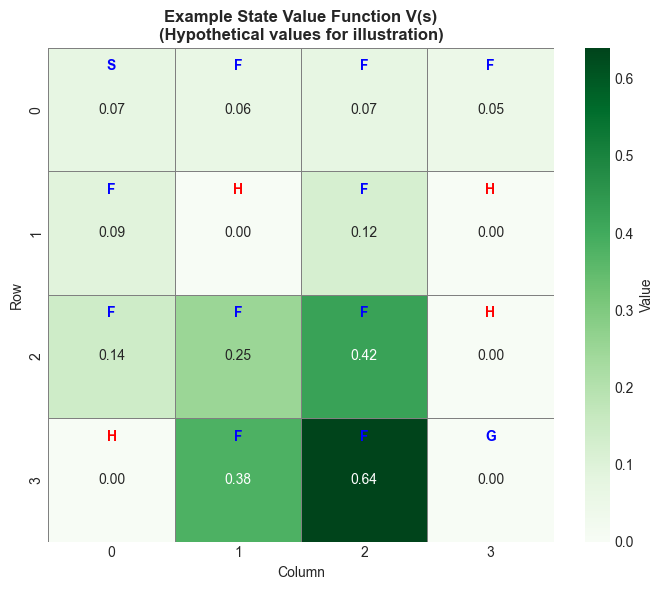

This heatmap shows what a learned Value Function might look like:
- Green = higher value (better states)
- White = lower value (worse states)
- Holes (H) and Goal (G) have value 0 (terminal states)
- States closer to the Goal have higher values


In [16]:
# Visualize what a Value Function looks like as a heatmap
def visualize_value_function(V, title="State Value Function V(s)"):
    """Visualizes the value function as a heatmap on the FrozenLake grid."""
    V_grid = V.reshape((4, 4))
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Create heatmap
    im = sns.heatmap(V_grid, annot=True, fmt=".2f", cmap="Greens", 
                     cbar_kws={'label': 'Value'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    # Add cell labels (S, F, H, G)
    labels = [['S', 'F', 'F', 'F'],
              ['F', 'H', 'F', 'H'],
              ['F', 'F', 'F', 'H'],
              ['H', 'F', 'F', 'G']]
    
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, i + 0.15, labels[i][j], 
                   ha='center', va='center', fontsize=10, 
                   color='red' if labels[i][j] == 'H' else 'blue',
                   fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

# Example: Hypothetical value function (what we'd expect from a reasonable policy)
# Higher values near the goal, zero at holes and goal (terminal states)
dummy_V = np.array([
    0.07, 0.06, 0.07, 0.05,  # Top row - far from goal, low values
    0.09, 0.00, 0.12, 0.00,  # Second row - holes have 0
    0.14, 0.25, 0.42, 0.00,  # Third row - getting closer to goal
    0.00, 0.38, 0.64, 0.00   # Bottom row - hole at 12, high values near goal, 0 at goal
])

visualize_value_function(dummy_V, "Example State Value Function V(s)\n(Hypothetical values for illustration)")
plt.show()

print("This heatmap shows what a learned Value Function might look like:")
print("- Green = higher value (better states)")
print("- White = lower value (worse states)")
print("- Holes (H) and Goal (G) have value 0 (terminal states)")
print("- States closer to the Goal have higher values")

## 4.3 Model

A **model** predicts what the environment will do next:

- **Transition model** $P$: Predicts the next state
  $$P_{ss'}^a = P[S_{t+1} = s' | S_t = s, A_t = a]$$

- **Reward model** $R$: Predicts the next reward
  $$R_s^a = E[R_{t+1} | S_t = s, A_t = a]$$

Having a model allows the agent to "think ahead" and plan without actually taking actions.

> **Important Note:** In the code below, we access `env.unwrapped.P` to visualize the internal mechanics of the environment. This is for **educational purposes only**. In real-world Reinforcement Learning (specifically **Model-Free RL**), the agent **does not know** these transition probabilities beforehand. It must learn the optimal policy simply by interacting with the environment - just like we did in Section 2 when we took random actions and observed the results. Model-Free methods (like Q-Learning, which we'll cover later) are the most common approach in practice because real environments rarely provide their internal dynamics.

In [17]:
# Access FrozenLake's transition model
env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset()

print("FrozenLake Transition Model")
print("=" * 50)
print("\nThe environment provides the transition probabilities P(s'|s,a)")
print("\nFormat: env.unwrapped.P[state][action] = list of (probability, next_state, reward, done)")

# Example: Show transitions from state 0
state = 0
action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']

print(f"\n--- Transitions from State {state} (top-left corner) ---")
for action in range(4):
    print(f"\nAction {action} ({action_names[action]}):")
    for prob, next_state, reward, done in env.unwrapped.P[state][action]:
        if prob > 0:
            print(f"  → State {next_state} with probability {prob:.2f}, reward={reward}, done={done}")

env.close()

FrozenLake Transition Model

The environment provides the transition probabilities P(s'|s,a)

Format: env.unwrapped.P[state][action] = list of (probability, next_state, reward, done)

--- Transitions from State 0 (top-left corner) ---

Action 0 (LEFT):
  → State 0 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False
  → State 4 with probability 0.33, reward=0, done=False

Action 1 (DOWN):
  → State 0 with probability 0.33, reward=0, done=False
  → State 4 with probability 0.33, reward=0, done=False
  → State 1 with probability 0.33, reward=0, done=False

Action 2 (RIGHT):
  → State 4 with probability 0.33, reward=0, done=False
  → State 1 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False

Action 3 (UP):
  → State 1 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False


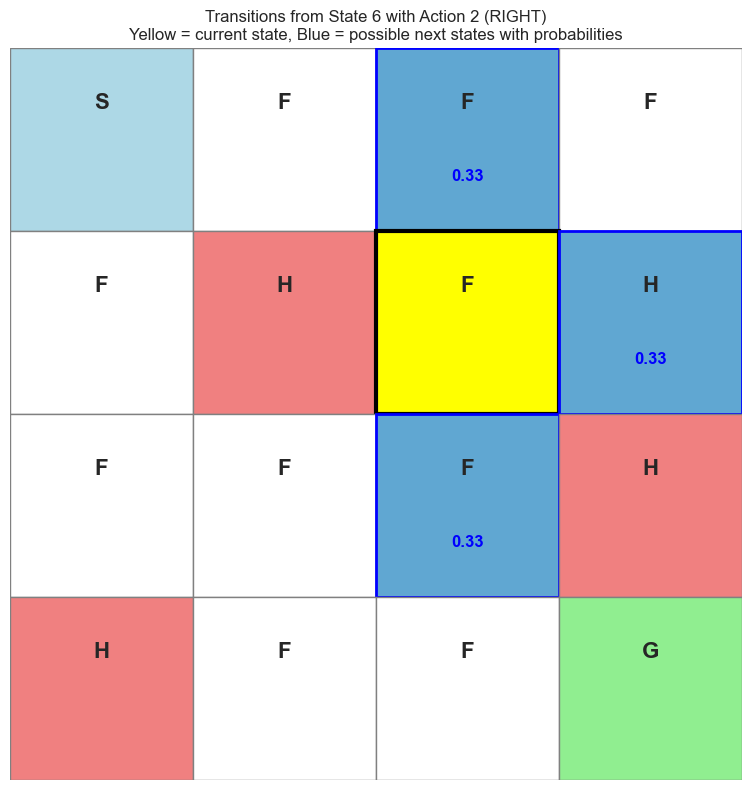


Notice: Due to the slippery ice, trying to go RIGHT from state 6
can result in going RIGHT, UP, or DOWN with equal probability!


In [18]:
# Visualize transition probabilities from a specific state
env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset()

def visualize_transitions(env, state, action):
    """Visualize the transition probabilities from a state given an action."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    # Get transition probabilities
    transitions = env.unwrapped.P[state][action]
    trans_dict = {next_s: prob for prob, next_s, _, _ in transitions if prob > 0}
    
    # Draw the grid
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            state_idx = i * ncol + j
            
            # Base color
            base_color = colors.get(cell, 'white')
            
            # Highlight current state
            if state_idx == state:
                facecolor = 'yellow'
                edgecolor = 'black'
                linewidth = 3
            elif state_idx in trans_dict:
                # Color intensity based on probability
                prob = trans_dict[state_idx]
                facecolor = plt.cm.Blues(0.3 + 0.7 * prob)
                edgecolor = 'blue'
                linewidth = 2
            else:
                facecolor = base_color
                edgecolor = 'gray'
                linewidth = 1
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(rect)
            
            # Add cell label
            ax.text(j + 0.5, nrow - 1 - i + 0.7, cell,
                   ha='center', va='center', fontsize=16, fontweight='bold')
            
            # Add probability if it's a target state
            if state_idx in trans_dict:
                ax.text(j + 0.5, nrow - 1 - i + 0.3, f'{trans_dict[state_idx]:.2f}',
                       ha='center', va='center', fontsize=12, color='blue', fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    
    action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
    ax.set_title(f'Transitions from State {state} with Action {action} ({action_names[action]})\n'
                f'Yellow = current state, Blue = possible next states with probabilities',
                fontsize=12)
    
    plt.tight_layout()
    return fig, ax

# Show transitions from state 6 (middle of the grid) with action RIGHT
visualize_transitions(env, state=6, action=2)  # RIGHT
plt.show()

print("\nNotice: Due to the slippery ice, trying to go RIGHT from state 6")
print("can result in going RIGHT, UP, or DOWN with equal probability!")

env.close()

### The Reward Model in FrozenLake

While the transition model tells us **where** we might end up, the reward model tells us **what reward** we'll receive. In FrozenLake, the reward model is very simple but illustrates the concept well.

#### FrozenLake's Reward Structure

The reward model $R_s^a = E[R_{t+1} | S_t = s, A_t = a]$ can be summarized as:

| Current State | Next State | Reward | Explanation |
|--------------|------------|--------|-------------|
| Any state | Goal (15) | +1 | Successfully reached the goal |
| Any state | Hole (5, 7, 11, 12) | 0 | Fell into a hole, episode ends |
| Any state | Any other state | 0 | Still navigating, no reward yet |

#### Expected Reward for Each State-Action Pair

Since the reward depends on **where we end up** (not just our action), we need to consider all possible transitions:

$$R_s^a = \sum_{s'} P(s'|s,a) \cdot R(s, a, s')$$

**Example: State 14, Action RIGHT (toward Goal)**

From state 14, if we choose RIGHT:
- 1/3 chance → State 15 (Goal) → Reward = +1
- 1/3 chance → State 10 (slip UP) → Reward = 0
- 1/3 chance → State 14 (slip DOWN, hits wall) → Reward = 0

Expected reward: $R_{14}^{RIGHT} = \frac{1}{3}(1) + \frac{1}{3}(0) + \frac{1}{3}(0) = \frac{1}{3} \approx 0.33$

**Example: State 6, Action RIGHT (toward Hole)**

From state 6, if we choose RIGHT:
- 1/3 chance → State 7 (Hole!) → Reward = 0
- 1/3 chance → State 2 (slip UP) → Reward = 0
- 1/3 chance → State 10 (slip DOWN) → Reward = 0

Expected reward: $R_6^{RIGHT} = 0$ (no chance of reaching Goal in one step)

#### The Complete Reward Model Table

For FrozenLake, the expected immediate reward for most state-action pairs is **0** because:

| Situation | Expected Reward | Why |
|-----------|-----------------|-----|
| Far from Goal | 0 | Can't reach Goal in one step |
| Adjacent to Goal | ~0.33 | 1/3 chance of reaching Goal (if action points toward it) |
| Next to Hole | 0 | Even falling in gives 0, not negative |
| At terminal states (Goal/Holes) | N/A | Episode already ended |

#### Why This Reward Model Makes Learning Hard

FrozenLake's reward model is an example of **sparse rewards**:

1. **Most transitions give 0 reward** - The agent gets no feedback for 99% of its actions
2. **No penalty for Holes** - Falling into a Hole gives the same reward (0) as a safe step
3. **Reward only at the very end** - Only reaching the Goal provides any signal

This is why FrozenLake, despite being simple, is actually challenging for RL algorithms. The agent must learn through rare successes which action sequences lead to the Goal.

#### Contrast: A Denser Reward Model

If we redesigned FrozenLake with denser rewards, learning would be easier:

| Event | Sparse (Original) | Dense (Alternative) |
|-------|-------------------|---------------------|
| Reach Goal | +1 | +10 |
| Fall in Hole | 0 | -10 |
| Move closer to Goal | 0 | +0.1 |
| Move away from Goal | 0 | -0.1 |
| Each step taken | 0 | -0.01 |

With dense rewards, the agent gets continuous feedback about its progress. However, designing good reward functions is itself a challenging problem (known as **reward shaping**).

---
# 5. Exploration vs Exploitation

One of the key challenges in RL is the **exploration-exploitation dilemma**:

- **Exploration**: Try new actions to discover their rewards
- **Exploitation**: Use known good actions to maximize reward

If we only exploit, we might miss better options. If we only explore, we waste time on suboptimal actions.

## Example: Restaurant Choice
- **Exploitation**: Go to your favorite restaurant (guaranteed good meal)
- **Exploration**: Try a new restaurant (might be better... or worse)

## Exploration vs Exploitation in FrozenLake

The exploration-exploitation dilemma is particularly interesting in FrozenLake because of its sparse rewards and stochastic transitions.

### The Challenge of Pure Exploitation

Imagine an agent that has only experienced a few episodes and found that going DOWN from state 0 led to falling into a Hole. If it purely exploits this knowledge:

```
"DOWN from state 0 → fell into Hole → avoid DOWN forever"
```

But this is wrong! The agent fell into the Hole because of **slippery ice**, not because DOWN is inherently bad. In fact, DOWN might be part of the optimal path. Without exploration, the agent would never discover this.

### The Challenge of Pure Exploration

On the other hand, if the agent always explores randomly:
- It has only ~1-4% chance of reaching the Goal (as we saw earlier)
- Even if it finds a good path, it won't consistently use it
- It keeps trying actions it already knows are bad

### Why Exploration is Critical in FrozenLake

| Reason | Explanation |
|--------|-------------|
| **Sparse rewards** | The agent might need hundreds of random episodes before accidentally reaching the Goal even once. Without exploration, it might never discover that +1 reward exists! |
| **Stochastic outcomes** | The same action can lead to different states. The agent needs multiple samples to learn the true transition probabilities. |
| **Misleading early experiences** | An early "lucky" or "unlucky" slip might give the wrong impression about an action's value. |
| **Multiple paths to Goal** | There might be several viable paths. Exploitation after finding one path means never discovering potentially better alternatives. |

### Exploration Strategies in FrozenLake

| Strategy | How It Works | FrozenLake Behavior |
|----------|--------------|---------------------|
| **ε-greedy** | With probability ε, take random action | Even after learning a good path, occasionally try alternatives |
| **Optimistic initialization** | Start with high value estimates | Assume unexplored states might lead to Goal, encouraging visits |
| **UCB (Upper Confidence Bound)** | Prefer actions with uncertain outcomes | Visit state-action pairs that haven't been tried often |
| **Decaying ε** | Reduce ε over time | Explore a lot early, then settle into exploiting the best known path |

### A Concrete Example

Consider an agent at **state 10** that has learned:
- DOWN reached Goal once (Q = 0.5)
- RIGHT fell into Hole at state 11 (Q = 0.0)
- LEFT and UP never tried (Q = 0.0, initialized)

**Pure exploitation**: Always go DOWN
- Misses the fact that LEFT might also be safe and could be useful from other states

**ε-greedy (ε = 0.1)**: 90% DOWN, 10% random
- Occasionally tries LEFT or UP
- Discovers that LEFT is also safe (leads to state 9)
- Learns more complete knowledge of the environment

**The payoff**: Better exploration leads to more robust policies that work even when the agent slips unexpectedly.

## Common Strategy: ε-Greedy

With probability $1-\epsilon$: choose the best known action (exploit)  
With probability $\epsilon$: choose a random action (explore)

Epsilon-Greedy Policy Demonstration

Q-values for state 0: [1.0, 5.0, 2.0, 3.0]
Best action: 1 (DOWN) with Q-value 5.0


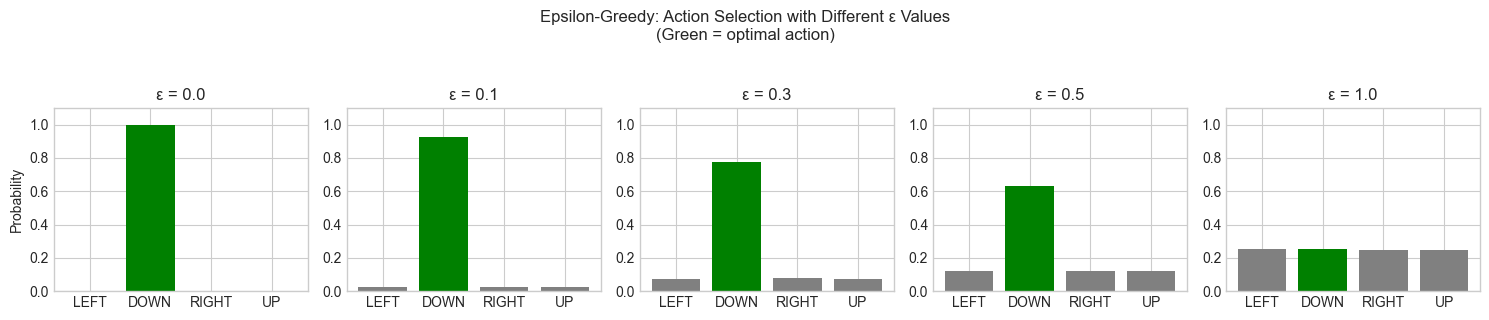


ε = 0.0: Always exploit (100% best action)
ε = 1.0: Always explore (25% each action)
ε = 0.1: Mostly exploit with some exploration (typical in practice)


In [19]:
# Implement epsilon-greedy exploration
def epsilon_greedy_policy(Q, state, epsilon):
    """
    Epsilon-greedy policy.
    
    Args:
        Q: Action-value function (dict or 2D array)
        state: Current state
        epsilon: Exploration probability
    
    Returns:
        action: Selected action
    """
    if np.random.random() < epsilon:
        # Explore: random action
        return np.random.randint(len(Q[state]))
    else:
        # Exploit: best action
        return np.argmax(Q[state])

# Demonstrate epsilon-greedy
print("Epsilon-Greedy Policy Demonstration")
print("=" * 50)

# Suppose we have learned these Q-values for state 0
# Q[state][action] = expected return
Q = {0: [1.0, 5.0, 2.0, 3.0]}  # Action 1 (DOWN) is best with value 5.0

print(f"\nQ-values for state 0: {Q[0]}")
print(f"Best action: 1 (DOWN) with Q-value 5.0")

# Count actions taken with different epsilon values
n_samples = 10000
epsilons = [0.0, 0.1, 0.3, 0.5, 1.0]

fig, axes = plt.subplots(1, len(epsilons), figsize=(15, 3))

for idx, epsilon in enumerate(epsilons):
    actions = [epsilon_greedy_policy(Q, 0, epsilon) for _ in range(n_samples)]
    counts = np.bincount(actions, minlength=4)
    
    colors = ['gray' if i != 1 else 'green' for i in range(4)]
    axes[idx].bar(['LEFT', 'DOWN', 'RIGHT', 'UP'], counts / n_samples, color=colors)
    axes[idx].set_title(f'ε = {epsilon}')
    axes[idx].set_ylim(0, 1.1)
    if idx == 0:
        axes[idx].set_ylabel('Probability')

plt.suptitle('Epsilon-Greedy: Action Selection with Different ε Values\n(Green = optimal action)', 
             fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

print("\nε = 0.0: Always exploit (100% best action)")
print("ε = 1.0: Always explore (25% each action)")
print("ε = 0.1: Mostly exploit with some exploration (typical in practice)")

---
# 6. Prediction vs Control

Two fundamental problems in RL:

## 6.1 Prediction (Policy Evaluation)
- **Goal**: Given a policy $\pi$, estimate the value function $V^\pi$ or $Q^\pi$
- **Question**: "How good is this policy?"

## 6.2 Control (Policy Optimization)
- **Goal**: Find the optimal policy $\pi^*$ that maximizes value
- **Question**: "What is the best policy?"

Control often builds on prediction: if we can evaluate policies, we can compare them and find the best one.

## Prediction vs Control in FrozenLake

Let's make these abstract concepts concrete with FrozenLake examples.

### Prediction: "How Good is the Random Policy?"

Suppose we have a **uniform random policy** (25% chance for each action). The prediction problem asks:

> "If I follow this random policy, what's my expected return from each state?"

| State | $V^{\pi_{random}}(s)$ | Interpretation |
|-------|----------------------|----------------|
| 0 (Start) | ~0.014 | From the start, random walking reaches Goal ~1.4% of the time |
| 10 (Near Goal) | ~0.05 | Even close to Goal, random actions rarely succeed |
| 14 (Adjacent to Goal) | ~0.15 | Best position, but still low due to random actions |
| 5, 7, 11, 12 (Holes) | 0 | Terminal states - no future rewards possible |

**Why do prediction?**
- Understand how well a policy performs
- Compare different policies
- Build toward finding better policies

### Control: "What's the Best Way to Navigate?"

The control problem asks:

> "What action should I take in each state to maximize my chance of reaching the Goal?"

| State | Optimal Action | Why |
|-------|---------------|-----|
| 0 (Start) | DOWN or LEFT | Moves toward safe left-side path, away from Hole at state 5 |
| 4 | DOWN | Continues down the safe left corridor |
| 8 | RIGHT | Start moving toward Goal |
| 9 | DOWN | Head toward state 13 |
| 10 | DOWN | Move toward state 14, adjacent to Goal |
| 14 | RIGHT | One step to Goal! |

The optimal policy $\pi^*$ achieves a much higher success rate (~74% with non-slippery ice, ~30-40% with slippery ice) compared to the random policy's ~1.4%.

### The Relationship: Prediction Enables Control

Control algorithms typically use prediction as a building block:

```
┌─────────────────────────────────────────────────────────┐
│                    CONTROL LOOP                         │
│                                                         │
│   1. Start with some policy π                          │
│                     ↓                                   │
│   2. PREDICTION: Evaluate π → compute V^π or Q^π       │
│                     ↓                                   │
│   3. IMPROVEMENT: Update π based on values             │
│         (e.g., be greedy w.r.t. Q^π)                   │
│                     ↓                                   │
│   4. Repeat until policy stops improving               │
│                     ↓                                   │
│   5. Output: Optimal policy π*                         │
└─────────────────────────────────────────────────────────┘
```

### Concrete Example: Improving a Policy in FrozenLake

**Step 1: Start with random policy**
- $\pi(s) = $ uniform random for all states

**Step 2: Prediction - Evaluate this policy**
- Compute $Q^{\pi}(s, a)$ for all state-action pairs
- Example: $Q^{\pi}(14, RIGHT) = 0.05$, $Q^{\pi}(14, LEFT) = 0.02$

**Step 3: Improvement - Be greedy**
- New policy: $\pi'(14) = RIGHT$ (because $Q^{\pi}(14, RIGHT) > Q^{\pi}(14, LEFT)$)
- Do this for all states

**Step 4: Repeat**
- Evaluate $\pi'$, improve to $\pi''$, and so on
- Eventually converge to optimal policy $\pi^*$

### Why Both Problems Matter

| Problem | FrozenLake Application | Real-World Analogy |
|---------|----------------------|-------------------|
| **Prediction** | "If I always go DOWN, what's my success rate?" | "If I invest in this stock, what's my expected return?" |
| **Control** | "What's the best action in each state?" | "How should I allocate my portfolio to maximize returns?" |

In the upcoming notebooks, we'll learn specific algorithms for both:
- **Prediction**: Policy Evaluation, Monte Carlo estimation, TD learning
- **Control**: Policy Iteration, Value Iteration, Q-Learning, SARSA

---
# 7. Summary

In this notebook, we covered the fundamental concepts of Reinforcement Learning:

**1. What is Reinforcement Learning?**
- Key characteristics: No supervisor, delayed feedback, sequential data, actions affect future
- The reward signal and reward hypothesis
- Sequential decision making

**2. The Agent-Environment Interface**
- The interaction loop of observations, actions, and rewards
- History and its role in decision making

**3. State and the Markov Property**
- "The future is independent of the past, given the present"
- Fully observable (MDP) vs partially observable (POMDP) environments

**4. Components of an RL Agent**
- **Policy ($\pi$)**: How to behave (deterministic vs stochastic)
- **Value Function ($V$, $Q$)**: How good states/actions are
- **Model**: How the environment works (transitions and rewards)

**5. Exploration vs Exploitation**
- The dilemma of trying new things vs using known good actions
- Strategies: ε-greedy, optimistic initialization, UCB

**6. Prediction vs Control**
- Prediction: Evaluate how good a policy is
- Control: Find the optimal policy

## Next Steps

In the next notebook (**02_mdp_and_bellman.ipynb**), we'll dive deeper into:
- Markov Decision Processes (MDPs)
- Markov Reward Processes (MRPs)
- The Bellman Equations

In [20]:
print("Congratulations! You've completed Part 1 of the RL Tutorial!")
print("\nKey takeaways:")
print("- RL agents learn from interaction with an environment")
print("- The Markov property allows us to use just the current state")
print("- Policies, value functions, and models are the building blocks")
print("- Balancing exploration and exploitation is crucial")
print("\nNext: 02_mdp_and_bellman.ipynb")

Congratulations! You've completed Part 1 of the RL Tutorial!

Key takeaways:
- RL agents learn from interaction with an environment
- The Markov property allows us to use just the current state
- Policies, value functions, and models are the building blocks
- Balancing exploration and exploitation is crucial

Next: 02_mdp_and_bellman.ipynb
